In [1]:
pip install -r https://raw.githubusercontent.com/rizki96/ds_challenge/master/requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [2]:
import io
import bz2
import pandas as pd
import numpy as np
import geohash
import time
import datetime
import pprint
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import requests
from math import ceil
from math import sin, cos, sqrt, atan2, radians
from sklearn import preprocessing
from sklearn.cluster import DBSCAN
from shapely.geometry import MultiPoint
from geopy.distance import great_circle
from pandas.plotting import register_matplotlib_converters
from collections import OrderedDict
from itertools import islice
from keras.models import load_model

register_matplotlib_converters()

Using TensorFlow backend.


In [3]:
# from local data file
trf_df = pd.read_csv('training.csv.bz2', compression='bz2', header=0, sep=',', quotechar='"')
trf_df_sort = trf_df.sort_values(by=['day', 'timestamp'])

# from remote data file
#url="https://github.com/rizki96/ds_challenge/blob/master/Traffic%20Management/training.csv.bz2?raw=true"
#s=requests.get(url).content
#data = bz2.decompress(s)
#trf_df = pd.read_csv(io.BytesIO(data), header=0, sep=',', quotechar='"')
#trf_df_sort = trf_df.sort_values(by=['day', 'timestamp'])

In [4]:
trf_df_sort[:5]

,geohash6,day,timestamp,demand
2289,qp09sx,1,0:0,0.021212
3149,qp0dhg,1,0:0,0.013217
11052,qp03x5,1,0:0,0.157956
23011,qp09bw,1,0:0,0.001262
26180,qp03wn,1,0:0,0.032721


In [5]:
trf_df_sort["dts_cal"] = [datetime.datetime.strptime('2019-03-31 00:00:00.00', '%Y-%m-%d %H:%M:%S.%f') + datetime.timedelta(days=day, hours=int(timestamp.split(":")[0]), minutes=int(timestamp.split(":")[1])) for day,timestamp in trf_df_sort[["day", "timestamp"]].values]

In [6]:
trf_df_sort[:5]

,geohash6,day,timestamp,demand,dts_cal
2289,qp09sx,1,0:0,0.021212,2019-04-01
3149,qp0dhg,1,0:0,0.013217,2019-04-01
11052,qp03x5,1,0:0,0.157956,2019-04-01
23011,qp09bw,1,0:0,0.001262,2019-04-01
26180,qp03wn,1,0:0,0.032721,2019-04-01


# convert geohash into latitude longitude

In [7]:
trf_df_sort.loc[:, 'latlon'] = trf_df_sort.geohash6.map(lambda x: geohash.decode(x))
trf_df_sort['lat'] = [ll[0][0] for ll in trf_df_sort[['latlon']].values]
trf_df_sort['lon'] = [ll[0][1] for ll in trf_df_sort[['latlon']].values]

In [8]:
trf_df_sort[:5]

,geohash6,day,timestamp,demand,dts_cal,latlon,lat,lon
2289,qp09sx,1,0:0,0.021212,2019-04-01,"(-5.32012939453125, 90.9063720703125)",-5.320129,90.906372
3149,qp0dhg,1,0:0,0.013217,2019-04-01,"(-5.25421142578125, 90.9173583984375)",-5.254211,90.917358
11052,qp03x5,1,0:0,0.157956,2019-04-01,"(-5.34210205078125, 90.6646728515625)",-5.342102,90.664673
23011,qp09bw,1,0:0,0.001262,2019-04-01,"(-5.28167724609375, 90.7305908203125)",-5.281677,90.730591
26180,qp03wn,1,0:0,0.032721,2019-04-01,"(-5.32562255859375, 90.6207275390625)",-5.325623,90.620728


# week 1 and week 2 data

In [9]:
initial_day = 1
num_of_days = 14
range_btwn_pts = 1 # in km
min_samples = 1
trf_week1 = pd.DataFrame(trf_df_sort[(trf_df_sort.day >= initial_day) & (trf_df_sort.day < (initial_day + num_of_days))])

In [10]:
trf_week1[:5]

,geohash6,day,timestamp,demand,dts_cal,latlon,lat,lon
2289,qp09sx,1,0:0,0.021212,2019-04-01,"(-5.32012939453125, 90.9063720703125)",-5.320129,90.906372
3149,qp0dhg,1,0:0,0.013217,2019-04-01,"(-5.25421142578125, 90.9173583984375)",-5.254211,90.917358
11052,qp03x5,1,0:0,0.157956,2019-04-01,"(-5.34210205078125, 90.6646728515625)",-5.342102,90.664673
23011,qp09bw,1,0:0,0.001262,2019-04-01,"(-5.28167724609375, 90.7305908203125)",-5.281677,90.730591
26180,qp03wn,1,0:0,0.032721,2019-04-01,"(-5.32562255859375, 90.6207275390625)",-5.325623,90.620728


# day 1 to day 14 cluster

In [11]:
day_ids = list(range(1,15))
trf_day1 = pd.DataFrame(trf_week1[trf_week1.day.isin(day_ids)])
latlon = trf_day1.groupby('geohash6')['geohash6'].unique().apply(lambda x: geohash.decode(x[0]))
coords = np.array([idx for idx in latlon])
#coords = trf_day1[['lat', 'lon']].values

In [12]:
start_time = time.time()
kms_per_radian = 6371.0088
epsilon = range_btwn_pts / kms_per_radian
db = DBSCAN(eps=epsilon, min_samples=min_samples, algorithm='ball_tree', metric='haversine').fit(np.radians(coords))
cluster_labels = db.labels_
num_clusters = len(set(cluster_labels))
# mark as -1 for outliers
clusters = pd.Series([coords[cluster_labels == n] for n in range(-1, num_clusters) if coords[cluster_labels == n].any()])
#clusters = pd.Series([coords[cluster_labels == n] for n in range(num_clusters) if coords[cluster_labels == n].any()])
#num_clusters = len(clusters)
elapsed_time = time.time() - start_time
print('Time taken to cluster: {} secs'.format(elapsed_time))
print('Number of day {} to day {} clusters: {}'.format(day_ids[0], day_ids[-1], num_clusters))
clusters

Time taken to cluster: 0.04289078712463379 secs
Number of day 1 to day 14 clusters: 82


0     [[-5.48492431640625, 90.6536865234375], [-5.47...
1     [[-5.46295166015625, 90.6536865234375], [-5.45...
2     [[-5.48492431640625, 90.6646728515625], [-5.47...
3     [[-5.48492431640625, 90.6756591796875], [-5.47...
4     [[-5.48492431640625, 90.6866455078125], [-5.47...
5     [[-5.48492431640625, 90.6976318359375], [-5.47...
6     [[-5.41351318359375, 90.5877685546875], [-5.40...
7     [[-5.41351318359375, 90.5987548828125], [-5.40...
8     [[-5.41351318359375, 90.6097412109375], [-5.40...
9               [[-5.43548583984375, 90.6427001953125]]
10              [[-5.43548583984375, 90.6536865234375]]
11    [[-5.41351318359375, 90.6207275390625], [-5.40...
12    [[-5.41351318359375, 90.6317138671875], [-5.40...
13    [[-5.41351318359375, 90.6427001953125], [-5.40...
14    [[-5.41351318359375, 90.6536865234375], [-5.40...
15    [[-5.41900634765625, 90.6646728515625], [-5.41...
16    [[-5.30914306640625, 90.5987548828125], [-5.30...
17              [[-5.29266357421875, 90.62072753

# cluster centermost_points

In [13]:
def get_centermost_point(cluster):
    centroid = (MultiPoint(cluster).centroid.x, MultiPoint(cluster).centroid.y)
    centermost_point = min(cluster, key=lambda point: great_circle(point, centroid).m)
    return tuple(centermost_point)
centermost_points = clusters.map(get_centermost_point)
centermost_points

0     (-5.48492431640625, 90.6536865234375)
1     (-5.45745849609375, 90.6536865234375)
2     (-5.45745849609375, 90.6646728515625)
3     (-5.36407470703125, 90.6756591796875)
4     (-5.36407470703125, 90.6866455078125)
5     (-5.36407470703125, 90.6976318359375)
6     (-5.36407470703125, 90.5877685546875)
7     (-5.36956787109375, 90.5987548828125)
8     (-5.35858154296875, 90.6097412109375)
9     (-5.43548583984375, 90.6427001953125)
10    (-5.43548583984375, 90.6536865234375)
11    (-5.35858154296875, 90.6207275390625)
12    (-5.34210205078125, 90.6317138671875)
13    (-5.32562255859375, 90.6427001953125)
14    (-5.32562255859375, 90.6536865234375)
15    (-5.32562255859375, 90.6646728515625)
16    (-5.30914306640625, 90.5987548828125)
17    (-5.29266357421875, 90.6207275390625)
18    (-5.36407470703125, 90.7086181640625)
19    (-5.35858154296875, 90.7196044921875)
20    (-5.40802001953125, 90.7305908203125)
21    (-5.45745849609375, 90.7415771484375)
22    (-5.46295166015625, 90.752

In [14]:
lats, lons = zip(*centermost_points)
rep_points = pd.DataFrame({'lon':lons, 'lat':lats})

In [15]:
rs = rep_points.apply(lambda row: trf_day1[(trf_day1['lat']==row['lat']) & (trf_day1['lon']==row['lon'])].iloc[0], axis=1)
rs[-5:]

,geohash6,day,timestamp,demand,dts_cal,latlon,lat,lon
77,qp0d0t,1,10:15,0.005558,2019-04-01 10:15:00,"(-5.24322509765625, 90.7305908203125)",-5.243225,90.730591
78,qp0d4j,3,7:45,0.018785,2019-04-03 07:45:00,"(-5.24322509765625, 90.7965087890625)",-5.243225,90.796509
79,qp0d4q,1,0:0,0.004235,2019-04-01 00:00:00,"(-5.23773193359375, 90.8074951171875)",-5.237732,90.807495
80,qp0d5m,1,10:30,0.001676,2019-04-01 10:30:00,"(-5.24322509765625, 90.8514404296875)",-5.243225,90.851440
81,qp0d5t,1,1:15,0.002917,2019-04-01 01:15:00,"(-5.24322509765625, 90.8624267578125)",-5.243225,90.862427


# cluster member and centermost_point visualization

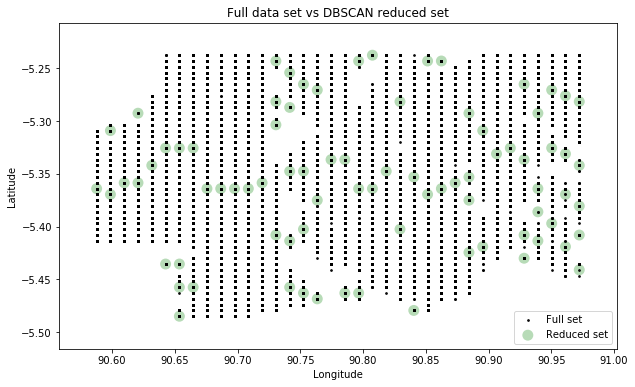

In [16]:
fig, ax = plt.subplots(figsize=[10, 6])
rs_scatter = ax.scatter(rs['lon'], rs['lat'], c='#99cc99', edgecolor='None', alpha=0.7, s=120)
df_scatter = ax.scatter(trf_day1['lon'], trf_day1['lat'], c='k', alpha=0.9, s=3)
ax.set_title('Full data set vs DBSCAN reduced set')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.legend([df_scatter, rs_scatter], ['Full set', 'Reduced set'], loc='lower right')
plt.show()

# set label and is_centroid to cluster

In [17]:
# map latlon clusters to geohash clusters
latlon_maps = {tuple(g): idx for idx,c in enumerate(clusters) for g in clusters[idx]}

# cluster_labels
trf_day1['cluster_ids'] = [latlon_maps[t] for t in trf_day1['latlon']]

In [18]:
trf_day1[:5]

,geohash6,day,timestamp,demand,dts_cal,latlon,lat,lon,cluster_ids
2289,qp09sx,1,0:0,0.021212,2019-04-01,"(-5.32012939453125, 90.9063720703125)",-5.320129,90.906372,51
3149,qp0dhg,1,0:0,0.013217,2019-04-01,"(-5.25421142578125, 90.9173583984375)",-5.254211,90.917358,52
11052,qp03x5,1,0:0,0.157956,2019-04-01,"(-5.34210205078125, 90.6646728515625)",-5.342102,90.664673,15
23011,qp09bw,1,0:0,0.001262,2019-04-01,"(-5.28167724609375, 90.7305908203125)",-5.281677,90.730591,44
26180,qp03wn,1,0:0,0.032721,2019-04-01,"(-5.32562255859375, 90.6207275390625)",-5.325623,90.620728,11


In [19]:
trf_day1 = trf_day1.sort_values(by=['cluster_ids', 'dts_cal', 'demand'])
trf_day1['is_centroid'] = [(rs['geohash6'][y] == x) for x,y in trf_day1[['geohash6', 'cluster_ids']].values]

In [20]:
trf_day1[-5:]

,geohash6,day,timestamp,demand,dts_cal,latlon,lat,lon,cluster_ids,is_centroid
3227500,qp0d5t,12,9:0,0.012086,2019-04-12 09:00:00,"(-5.24322509765625, 90.8624267578125)",-5.243225,90.862427,81,True
3560473,qp0d5t,13,8:15,0.000757,2019-04-13 08:15:00,"(-5.24322509765625, 90.8624267578125)",-5.243225,90.862427,81,True
1232769,qp0d5t,14,4:45,0.000966,2019-04-14 04:45:00,"(-5.24322509765625, 90.8624267578125)",-5.243225,90.862427,81,True
786377,qp0d5t,14,7:30,0.006390,2019-04-14 07:30:00,"(-5.24322509765625, 90.8624267578125)",-5.243225,90.862427,81,True
1131024,qp0d5t,14,9:0,0.018448,2019-04-14 09:00:00,"(-5.24322509765625, 90.8624267578125)",-5.243225,90.862427,81,True


# set highest_demand and average demand to cluster

In [21]:
trf_day1_avg_demand = trf_day1.groupby(['cluster_ids','geohash6'])['demand'].apply(lambda x: np.mean(x)).sort_values(ascending=False)
trf_day1['highest_demand'] = [trf_day1_avg_demand[x].index[0] == y for x,y in trf_day1[['cluster_ids', 'geohash6']].values]
trf_day1['avg_demand'] = [trf_day1_avg_demand[x][y] for x,y in trf_day1[['cluster_ids', 'geohash6']].values]

In [22]:
#trf_day1[(trf_day1.highest_demand == True) & (trf_day1.geohash6 == 'qp09jt')][:5]
trf_day1[(trf_day1.highest_demand == True)][-5:]

,geohash6,day,timestamp,demand,dts_cal,latlon,lat,lon,cluster_ids,is_centroid,highest_demand,avg_demand
3227500,qp0d5t,12,9:0,0.012086,2019-04-12 09:00:00,"(-5.24322509765625, 90.8624267578125)",-5.243225,90.862427,81,True,True,0.007512
3560473,qp0d5t,13,8:15,0.000757,2019-04-13 08:15:00,"(-5.24322509765625, 90.8624267578125)",-5.243225,90.862427,81,True,True,0.007512
1232769,qp0d5t,14,4:45,0.000966,2019-04-14 04:45:00,"(-5.24322509765625, 90.8624267578125)",-5.243225,90.862427,81,True,True,0.007512
786377,qp0d5t,14,7:30,0.006390,2019-04-14 07:30:00,"(-5.24322509765625, 90.8624267578125)",-5.243225,90.862427,81,True,True,0.007512
1131024,qp0d5t,14,9:0,0.018448,2019-04-14 09:00:00,"(-5.24322509765625, 90.8624267578125)",-5.243225,90.862427,81,True,True,0.007512


# visualize time, center point and highest demand

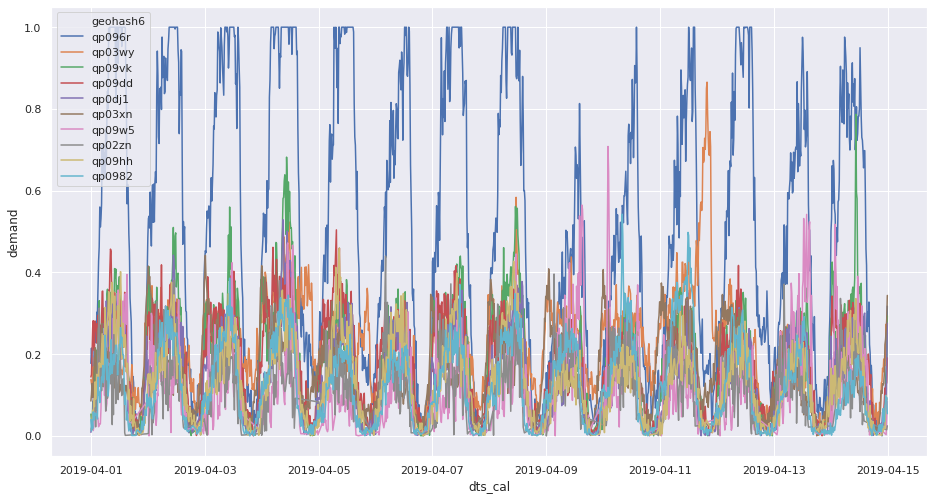

In [23]:
# observation 10 samples cluster's center point demand
trf_day1_center = pd.DataFrame(trf_day1[(trf_day1.is_centroid == True)].sort_values(by=['avg_demand', 'cluster_ids'], ascending=False))
top_clusters = list(OrderedDict.fromkeys([c[0] for c in trf_day1_center[['cluster_ids']].values]))[0:10]
top_trf_day1_center = trf_day1_center[(trf_day1_center.cluster_ids.isin(top_clusters))]
#trf_day1_cl0_others = pd.DataFrame(trf_day1[(trf_day1.is_centroid == False) & (trf_day1.cluster_ids == 0) & (trf_day1.demand > 0.0)])
#ax = sns.lineplot(x="dts_cal", y="demand", hue="geohash6", data=trf_day1_cl0_others, legend="full")
#for l in ax.lines:
#    l.set_linestyle("--")
sns.set(style="darkgrid")
sns.set(rc={'figure.figsize':(15.7,8.27)})
sns.lineplot(x="dts_cal", y="demand", hue="geohash6", data=top_trf_day1_center, legend="full")
plt.show()

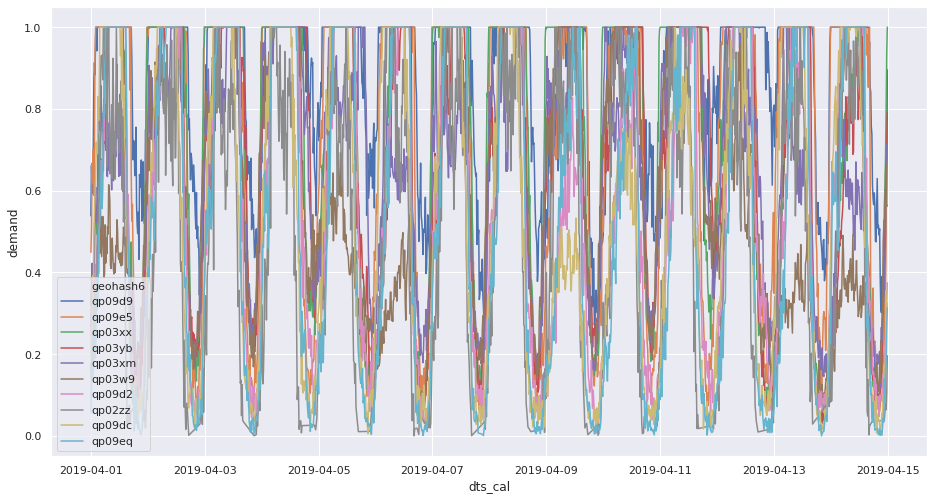

In [24]:
# observation 10 samples cluster's highest demand
trf_day1_highest = pd.DataFrame(trf_day1[(trf_day1.highest_demand == True)].sort_values(by=['avg_demand', 'cluster_ids'], ascending=False))
top_clusters = list(OrderedDict.fromkeys([c[0] for c in trf_day1_highest[['cluster_ids']].values]))[0:10]
top_trf_day1_highest = trf_day1_highest[(trf_day1_highest.cluster_ids.isin(top_clusters))]
#trf_week1_cl0_lower = pd.DataFrame(trf_week1[(trf_week1.highest_demand == False) & (trf_week1.cluster_ids == 0) & (trf_week1.demand > 0.0)])
#ax = sns.lineplot(x="dts_cal", y="demand", hue="geohash6", data=trf_week1_cl0_lower, legend="full")
#for l in ax.lines:
#    l.set_linestyle("--")
#    plt.setp(l,linewidth=1)
sns.set(style="darkgrid")
sns.set(rc={'figure.figsize':(15.7,8.27)})
sns.lineplot(x="dts_cal", y="demand", hue="geohash6", data=top_trf_day1_highest, legend="full")
plt.show()

# zero filling timeseries gap for cluster's highest demand

In [25]:
# looking for anomaly, is there any duplicate timeseries data (make sure it's unique)
unique = True
for c in list(OrderedDict.fromkeys([c[0] for c in trf_day1_highest[['cluster_ids']].values])):
    if not pd.Series(y for x,y in trf_day1_highest[['cluster_ids', 'dts_cal']].values if x == c).is_unique:
        print('timeseries cluster %s is not unique' % (c,))
        unique = False
if unique:
    print('all timeseries clusters are unique')

all timeseries clusters are unique


In [26]:
# reinitial dataframe, fill unset timestamp with zero
multiplier = len(day_ids)
trf_day1_complete = pd.DataFrame({'geohash6': [],
                                   'day': [],
                                   'timestamp': [],
                                   'demand': [],
                                   'dts_cal': [],
                                   'latlon': [],
                                   'lat': [], 'lon': [],
                                   'cluster_ids': [],
                                   'is_centroid': [],
                                   'highest_demand': [],
                                   'avg_demand': []})
interval_time = [datetime.timedelta(days=initial_day,minutes=15*t) for t in range(24*4*multiplier)]
start_date = datetime.datetime.strptime('2019-03-31 00:00:00.00', '%Y-%m-%d %H:%M:%S.%f')
gh = trf_day1_highest.groupby(['cluster_ids'])['geohash6'].apply(list)
demand = trf_day1_highest.groupby(['cluster_ids', 'dts_cal'])['demand'].apply(list)
avg_demand = trf_day1_highest.groupby(['cluster_ids'])['avg_demand'].apply(list)
highest_demand = trf_day1_highest.groupby(['cluster_ids'])['highest_demand'].apply(list)
is_centroid = trf_day1_highest.groupby(['cluster_ids'])['is_centroid'].apply(list)
cluster_list = list(OrderedDict.fromkeys([c[0] for c in trf_day1_highest[['cluster_ids']].values]))

trf_day1_complete['cluster_ids'] = [c for _ in range(24*4*multiplier) for c in cluster_list]
trf_day1_complete['geohash6'] = [gh[c][0] for _ in range(24*4*multiplier) for c in cluster_list]
trf_day1_complete['dts_cal'] = [(start_date + t) for t in interval_time for c in cluster_list]
trf_day1_complete['day'] = [int(t/(24*4)) + 1 for t in range(24*4*multiplier) for c in cluster_list]
trf_day1_complete['timestamp'] = ['%s:%s' % ((start_date + t).hour, (start_date + t).minute) for t in interval_time for c in cluster_list]
trf_day1_complete['avg_demand'] = [avg_demand[c][0] for _ in range(24*4*multiplier) for c in cluster_list]
trf_day1_complete['highest_demand'] = [highest_demand[c][0] for _ in range(24*4*multiplier) for c in cluster_list]
trf_day1_complete['is_centroid'] = [is_centroid[c][0] for _ in range(24*4*multiplier) for c in cluster_list]
trf_day1_complete['demand'] = [demand[c][start_date + t][0] if (start_date + t) in demand[c] else 0 for t in interval_time for c in cluster_list]
trf_day1_complete['latlon'] = [geohash.decode(gh[c][0]) for _ in range(24*4*multiplier) for c in cluster_list]
trf_day1_complete['lat'] = [geohash.decode(gh[c][0])[0] for _ in range(24*4*multiplier) for c in cluster_list]
trf_day1_complete['lon'] = [geohash.decode(gh[c][0])[1] for _ in range(24*4*multiplier) for c in cluster_list]
trf_day1_complete

,geohash6,day,timestamp,demand,dts_cal,latlon,lat,lon,cluster_ids,is_centroid,highest_demand,avg_demand
0,qp09d9,1,0:0,0.538371,2019-04-01 00:00:00,"(-5.35308837890625, 90.8184814453125)",-5.353088,90.818481,27,False,True,0.874390
1,qp09e5,1,0:0,0.449159,2019-04-01 00:00:00,"(-5.34210205078125, 90.8404541015625)",-5.342102,90.840454,31,False,True,0.757501
2,qp03xx,1,0:0,0.320478,2019-04-01 00:00:00,"(-5.32012939453125, 90.6866455078125)",-5.320129,90.686646,4,False,True,0.736486
3,qp03yb,1,0:0,0.244790,2019-04-01 00:00:00,"(-5.31463623046875, 90.6536865234375)",-5.314636,90.653687,14,False,True,0.685932
4,qp03xm,1,0:0,0.261962,2019-04-01 00:00:00,"(-5.33111572265625, 90.6756591796875)",-5.331116,90.675659,3,False,True,0.659123
5,qp03w9,1,0:0,0.383662,2019-04-01 00:00:00,"(-5.35308837890625, 90.6427001953125)",-5.353088,90.642700,13,False,True,0.589217
6,qp09d2,1,0:0,0.268345,2019-04-01 00:00:00,"(-5.35858154296875, 90.8074951171875)",-5.358582,90.807495,26,False,True,0.583550
7,qp02zz,1,0:0,0.176994,2019-04-01 00:00:00,"(-5.45196533203125, 90.6976318359375)",-5.451965,90.697632,5,False,True,0.564207
8,qp09dc,1,0:0,0.189483,2019-04-01 00:00:00,"(-5.35308837890625, 90.8294677734375)",-5.353088,90.829468,28,False,True,0.542363
9,qp09eq,1,0:0,0.055975,2019-04-01 00:00:00,"(-5.32562255859375, 90.8514404296875)",-5.325623,90.851440,30,False,True,0.538466


# visualize after zero fill gap

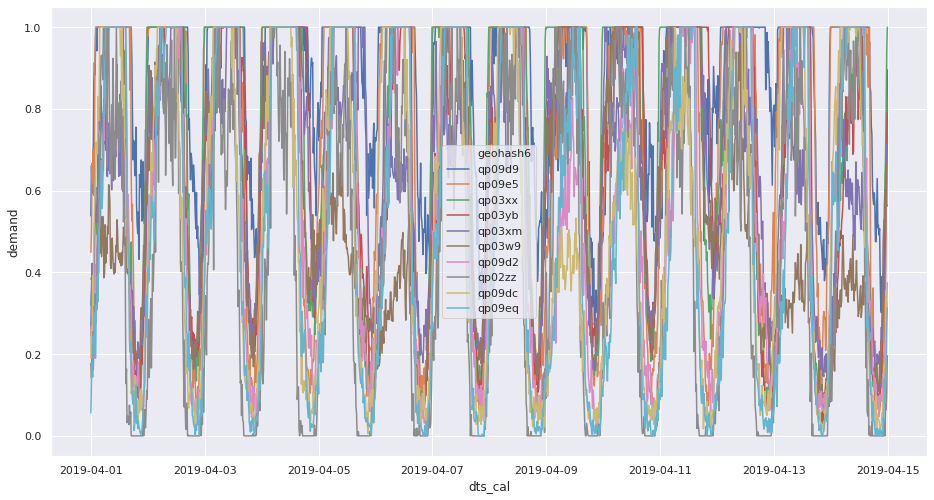

In [27]:
# observation 10 samples cluster's highest demand
top_clusters = list(OrderedDict.fromkeys([c[0] for c in trf_day1_complete[['cluster_ids']].values]))[0:10]
top_trf_day1_complete_highest = trf_day1_complete[(trf_day1_complete.cluster_ids.isin(top_clusters))]
#trf_week1_cl0_lower = pd.DataFrame(trf_week1[(trf_week1.highest_demand == False) & (trf_week1.cluster_ids == 0) & (trf_week1.demand > 0.0)])
#ax = sns.lineplot(x="dts_cal", y="demand", hue="geohash6", data=trf_week1_cl0_lower, legend="full")
#for l in ax.lines:
#    l.set_linestyle("--")
#    plt.setp(l,linewidth=1)
sns.set(style="darkgrid")
sns.set(rc={'figure.figsize':(15.7,8.27)})
sns.lineplot(x="dts_cal", y="demand", hue="geohash6", data=top_trf_day1_complete_highest, legend="full")
plt.show()

# timeseries prediction

In [28]:
# prepare sorted data
total_sequence_series = 24*4*multiplier # 15 minutes within 24*multiplier hours
#past_length = int(((multiplier-1) / multiplier)*total_sequence_series)
prediction_length = int(24*4*(multiplier/2))
trf_day1_complete_sort = trf_day1_complete.sort_values(by=['cluster_ids','dts_cal'], ascending=True)
print("total_sequence_series: %s, prediction_length: %s" % (total_sequence_series, prediction_length))
trf_day1_complete_sort[:5]

total_sequence_series: 1344, prediction_length: 672


,geohash6,day,timestamp,demand,dts_cal,latlon,lat,lon,cluster_ids,is_centroid,highest_demand,avg_demand
67,qp02yc,1,0:0,0.0,2019-04-01 00:00:00,"(-5.48492431640625, 90.6536865234375)",-5.484924,90.653687,0,True,True,0.018415
149,qp02yc,1,0:15,0.0,2019-04-01 00:15:00,"(-5.48492431640625, 90.6536865234375)",-5.484924,90.653687,0,True,True,0.018415
231,qp02yc,1,0:30,0.0,2019-04-01 00:30:00,"(-5.48492431640625, 90.6536865234375)",-5.484924,90.653687,0,True,True,0.018415
313,qp02yc,1,0:45,0.0,2019-04-01 00:45:00,"(-5.48492431640625, 90.6536865234375)",-5.484924,90.653687,0,True,True,0.018415
395,qp02yc,1,1:0,0.0,2019-04-01 01:00:00,"(-5.48492431640625, 90.6536865234375)",-5.484924,90.653687,0,True,True,0.018415


In [29]:
# grouping and prepare prerequisite data
start_date = datetime.datetime.strptime('2019-03-31 00:00:00.00', '%Y-%m-%d %H:%M:%S.%f')
cluster_list = list(set([c for c in trf_day1_complete_sort['cluster_ids']]))
demand = trf_day1_complete_sort.groupby(['cluster_ids', 'dts_cal'])['demand'].apply(list)

In [30]:
# weekly prediction using keras
from lib import keras_timeseries

# setup train and test data for keras
train_day1_ds = [[demand[c][start_date + t][0] for t in interval_time[:-prediction_length]] for c in cluster_list]
test_day1_ds = [[demand[c][start_date + t][0] for t in interval_time[total_sequence_series-prediction_length:]] for c in cluster_list]

X_mat = np.matrix(';'.join([' '.join([str(d) for d in ds]) for ds in train_day1_ds]))
X_data = X_mat.round(15).reshape(len(cluster_list), total_sequence_series-prediction_length, 1)
y_mat = np.matrix(';'.join([' '.join([str(d) for d in ds]) for ds in test_day1_ds]))
y_data = y_mat.round(15).reshape(len(cluster_list), prediction_length, 1)

test_count = int(0.5*X_data.shape[0])
test_count = test_count if test_count < 32 else 32*ceil(test_count / 32)
X_train = X_data[:-(X_data.shape[0]-test_count)]
X_test = X_data[X_data.shape[0]-test_count:]

#print(X_train.shape, X_test.shape)

y_train = y_data[:-(y_data.shape[0]-test_count)]
y_test = y_data[y_data.shape[0]-test_count:]

#print(y_train.shape, y_test.shape)

N = X_train.shape[0] # size of samples
T = X_train.shape[1] # length of each time series
train_batch_size = N # number of time series considered together: batch_size | N
T_after_cut = 24 # length of each cut part of the time series: T_after_cut | T
dim_in = X_train.shape[2] # dimension of input time series
dim_out = y_train.shape[2] # dimension of output time series
test_batch_size = X_test.shape[0]

inputs, outputs = \
    [keras_timeseries.stateful_cut(arr, train_batch_size, T_after_cut) for arr in \
    [X_train, y_train]]
inputs_test, outputs_test = \
    [keras_timeseries.stateful_cut(arr, test_batch_size, T_after_cut) for arr in \
    [X_test, y_test]]
#inputs, outputs, inputs_test, outputs_testtest_count = test_count if test_count < 32 else 32*ceil(test_count / 32)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Train on 1792 samples, validate on 1792 samples
Epoch 1/500
1792/1792 [==============================] - 1s 663us/step - loss: 0.0364 - val_loss: 0.0188
Epoch 2/500
1792/1792 [==============================] - 0s 204us/step - loss: 0.0277 - val_loss: 0.0153
Epoch 3/500
1792/1792 [==============================] - 0s 207us/step - loss: 0.0222 - val_loss: 0.0133
Epoch 4/500
1792/1792 [==============================] - 0s 210us/step - loss: 0.0189 - val_loss: 0.0123
Epoch 5/500
1792/1792 [==============================] - 0s 204us/step - loss: 0.0169 - val_loss: 0.0115
Epoch 6/500
1792/1792 [==============================] - 0s 205us/step - loss: 0.0154 - val_loss: 0.0108
Epoch 7/500
1792/1792 [==============================] - 0s 200us/step - loss: 0.0142 - val_loss: 0.0101
Epoch 8/500
1792/1792 [==============================] - 0s 207us/step - loss: 0.0133 - val_loss:

1792/1792 [==============================] - 0s 196us/step - loss: 0.0086 - val_loss: 0.0062
Epoch 73/500
1792/1792 [==============================] - 0s 200us/step - loss: 0.0086 - val_loss: 0.0062
Epoch 74/500
1792/1792 [==============================] - 0s 207us/step - loss: 0.0086 - val_loss: 0.0062
Epoch 75/500
1792/1792 [==============================] - 0s 206us/step - loss: 0.0086 - val_loss: 0.0062
Epoch 76/500
1792/1792 [==============================] - 0s 211us/step - loss: 0.0086 - val_loss: 0.0062
Epoch 77/500
1792/1792 [==============================] - 0s 249us/step - loss: 0.0086 - val_loss: 0.0062
Epoch 78/500
1792/1792 [==============================] - 0s 201us/step - loss: 0.0086 - val_loss: 0.0062
Epoch 79/500
1792/1792 [==============================] - 0s 206us/step - loss: 0.0086 - val_loss: 0.0062
Epoch 80/500
1792/1792 [==============================] - 0s 225us/step - loss: 0.0086 - val_loss: 0.0062
Epoch 81/500
1792/1792 [==============================] - 0

Epoch 149/500
1792/1792 [==============================] - 0s 197us/step - loss: 0.0083 - val_loss: 0.0061
Epoch 150/500
1792/1792 [==============================] - 0s 197us/step - loss: 0.0083 - val_loss: 0.0061
Epoch 151/500
1792/1792 [==============================] - 0s 216us/step - loss: 0.0083 - val_loss: 0.0061
Epoch 152/500
1792/1792 [==============================] - 0s 222us/step - loss: 0.0083 - val_loss: 0.0061
Epoch 153/500
1792/1792 [==============================] - 0s 209us/step - loss: 0.0083 - val_loss: 0.0061
Epoch 154/500
1792/1792 [==============================] - 0s 205us/step - loss: 0.0083 - val_loss: 0.0061
Epoch 155/500
1792/1792 [==============================] - 0s 205us/step - loss: 0.0083 - val_loss: 0.0061
Epoch 156/500
1792/1792 [==============================] - 0s 201us/step - loss: 0.0083 - val_loss: 0.0061
Epoch 157/500
1792/1792 [==============================] - 0s 220us/step - loss: 0.0083 - val_loss: 0.0061
Epoch 158/500
1792/1792 [============

1792/1792 [==============================] - 0s 197us/step - loss: 0.0082 - val_loss: 0.0061
Epoch 226/500
1792/1792 [==============================] - 0s 204us/step - loss: 0.0082 - val_loss: 0.0061
Epoch 227/500
1792/1792 [==============================] - 0s 206us/step - loss: 0.0082 - val_loss: 0.0061
Epoch 228/500
1792/1792 [==============================] - 0s 200us/step - loss: 0.0082 - val_loss: 0.0061
Epoch 229/500
1792/1792 [==============================] - 0s 205us/step - loss: 0.0082 - val_loss: 0.0061
Epoch 230/500
1792/1792 [==============================] - 0s 208us/step - loss: 0.0082 - val_loss: 0.0061
Epoch 231/500
1792/1792 [==============================] - 0s 204us/step - loss: 0.0082 - val_loss: 0.0061
Epoch 232/500
1792/1792 [==============================] - 0s 195us/step - loss: 0.0082 - val_loss: 0.0061
Epoch 233/500
1792/1792 [==============================] - 0s 196us/step - loss: 0.0082 - val_loss: 0.0061
Epoch 234/500
1792/1792 [==========================

1792/1792 [==============================] - 0s 202us/step - loss: 0.0082 - val_loss: 0.0061
Epoch 302/500
1792/1792 [==============================] - 0s 200us/step - loss: 0.0082 - val_loss: 0.0061
Epoch 303/500
1792/1792 [==============================] - 0s 207us/step - loss: 0.0082 - val_loss: 0.0061
Epoch 304/500
1792/1792 [==============================] - 0s 211us/step - loss: 0.0082 - val_loss: 0.0061
Epoch 305/500
1792/1792 [==============================] - 0s 219us/step - loss: 0.0082 - val_loss: 0.0061
Epoch 306/500
1792/1792 [==============================] - 0s 198us/step - loss: 0.0082 - val_loss: 0.0061
Epoch 307/500
1792/1792 [==============================] - 0s 198us/step - loss: 0.0082 - val_loss: 0.0061
Epoch 308/500
1792/1792 [==============================] - 0s 211us/step - loss: 0.0082 - val_loss: 0.0061
Epoch 309/500
1792/1792 [==============================] - 0s 207us/step - loss: 0.0082 - val_loss: 0.0061
Epoch 310/500
1792/1792 [==========================

1792/1792 [==============================] - 0s 211us/step - loss: 0.0082 - val_loss: 0.0061
Epoch 378/500
1792/1792 [==============================] - 0s 210us/step - loss: 0.0082 - val_loss: 0.0061
Epoch 379/500
1792/1792 [==============================] - 0s 202us/step - loss: 0.0082 - val_loss: 0.0061
Epoch 380/500
1792/1792 [==============================] - 0s 216us/step - loss: 0.0082 - val_loss: 0.0061
Epoch 381/500
1792/1792 [==============================] - 0s 213us/step - loss: 0.0082 - val_loss: 0.0061
Epoch 382/500
1792/1792 [==============================] - 0s 209us/step - loss: 0.0082 - val_loss: 0.0061
Epoch 383/500
1792/1792 [==============================] - 0s 204us/step - loss: 0.0082 - val_loss: 0.0061
Epoch 384/500
1792/1792 [==============================] - 0s 203us/step - loss: 0.0082 - val_loss: 0.0061
Epoch 385/500
1792/1792 [==============================] - 0s 225us/step - loss: 0.0082 - val_loss: 0.0061
Epoch 386/500
1792/1792 [==========================

1792/1792 [==============================] - 0s 213us/step - loss: 0.0082 - val_loss: 0.0061
Epoch 454/500
1792/1792 [==============================] - 0s 218us/step - loss: 0.0082 - val_loss: 0.0061
Epoch 455/500
1792/1792 [==============================] - 0s 217us/step - loss: 0.0082 - val_loss: 0.0061
Epoch 456/500
1792/1792 [==============================] - 0s 203us/step - loss: 0.0082 - val_loss: 0.0061
Epoch 457/500
1792/1792 [==============================] - 0s 200us/step - loss: 0.0082 - val_loss: 0.0061
Epoch 458/500
1792/1792 [==============================] - 0s 202us/step - loss: 0.0082 - val_loss: 0.0061
Epoch 459/500
1792/1792 [==============================] - 0s 203us/step - loss: 0.0082 - val_loss: 0.0061
Epoch 460/500
1792/1792 [==============================] - 0s 196us/step - loss: 0.0082 - val_loss: 0.0061
Epoch 461/500
1792/1792 [==============================] - 0s 211us/step - loss: 0.0082 - val_loss: 0.0061
Epoch 462/500
1792/1792 [==========================

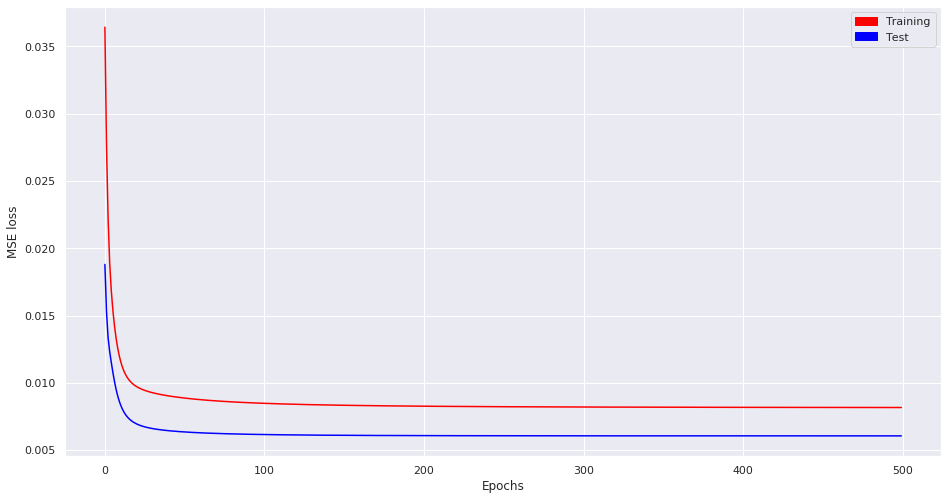

In [31]:
# building network and training
model = keras_timeseries.build_model(train_batch_size, int(total_sequence_series/T), dim_in, dim_out, T_after_cut)
epochs = 500
history = keras_timeseries.train_model(model, inputs, outputs, inputs_test, outputs_test,
                N, T, epochs, train_batch_size, test_batch_size, T_after_cut)
keras_timeseries.plotting(history)

# saving the model
model_path = 'model/keras-epoch%s-stateful-%sdays.lstm' % (epochs, len(day_ids))
model.save(model_path)

In [32]:
# predicting and evaluating
model = load_model(model_path)
# After 500 epochs: loss: 0.0082 / val_loss: 0.0061.

interval=64
first_idx = range(0, interval)
second_idx = range(len(cluster_list)-interval, len(cluster_list))

first_x = X_data[first_idx]
first_y = y_data[first_idx]
first_yhat = model.predict(first_x, batch_size=interval)

second_x = X_data[second_idx]
second_y = y_data[second_idx]
second_yhat = model.predict(second_x, batch_size=interval)

actual_x = [first_x[c] for c in first_idx]
actual_x.extend([second_x[c] for c in range(interval-(len(cluster_list)-interval), interval)])
actual_y = [first_y[c] for c in first_idx]
actual_y.extend([second_y[c] for c in range(interval-(len(cluster_list)-interval), interval)])
predicted_y = [first_yhat[c] for c in first_idx]
predicted_y.extend([second_yhat[c] for c in range(interval-(len(cluster_list)-interval), interval)])

result_df = pd.DataFrame({
    'actual_demand': [],
    'predicted_demand': [],
    'cluster_ids': [],
    'ts': []})

actual_x_df = pd.DataFrame([actual_x[c][t][0] for t in range(24*2*multiplier) for c in cluster_list])
actual_y_df = pd.DataFrame([actual_y[c][t][0] for t in range(24*2*multiplier) for c in cluster_list])
predicted_x_df = pd.DataFrame([float('nan') for _ in range(24*2*multiplier) for _ in cluster_list])
predicted_y_df = pd.DataFrame([predicted_y[c][t][0] for t in range(24*2*multiplier) for c in cluster_list])

result_df['cluster_ids'] = [c for _ in interval_time for c in cluster_list]
result_df['ts'] = [start_date + t for t in interval_time for _ in cluster_list]
actual_result = actual_x_df.append(actual_y_df)
predicted_result = predicted_x_df.append(predicted_y_df)
result_df = result_df.sort_values(['ts', 'cluster_ids'])
result_df['actual_demand'] = [res for res in actual_result[0]]
result_df['predicted_demand'] = [res for res in predicted_result[0]]

#result_df[result_df.cluster_ids == 0]
top_result_df = result_df[result_df.cluster_ids.isin(top_clusters)]

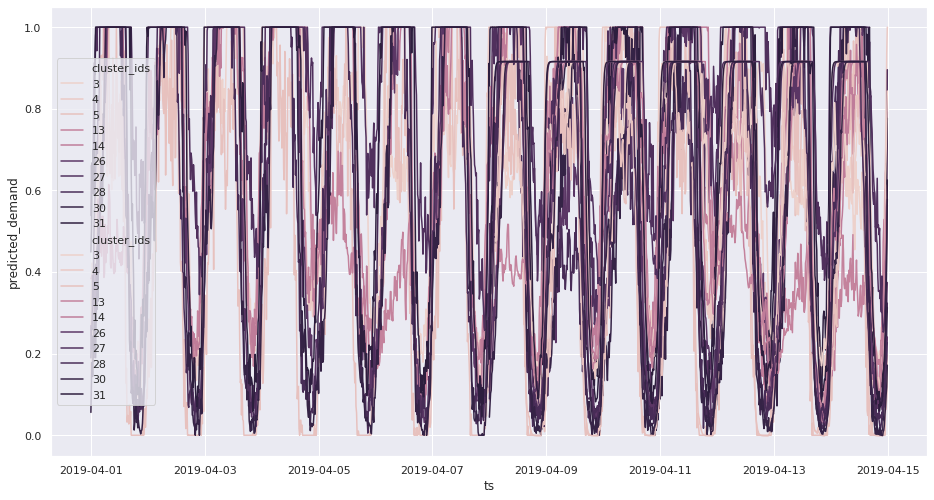

In [33]:
fig, ax = plt.subplots()
sns.set(style="darkgrid")
sns.set(rc={'figure.figsize':(15.7,8.27)})
ax = sns.lineplot(x="ts", y="actual_demand", hue="cluster_ids", ax=ax, data=top_result_df, legend="full")
ax = sns.lineplot(x="ts", y="predicted_demand", hue="cluster_ids", ax=ax, data=top_result_df, legend="full")

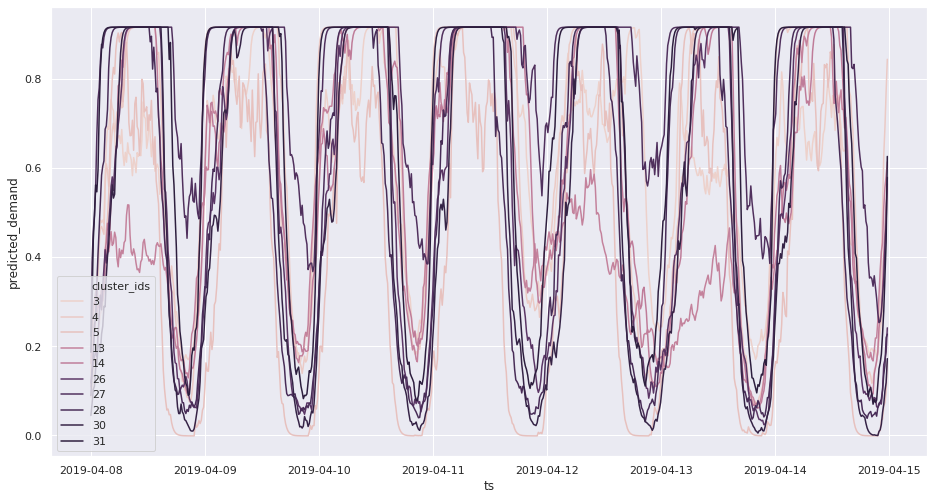

In [34]:
sns.set(style="darkgrid")
sns.set(rc={'figure.figsize':(15.7,8.27)})
sns.lineplot(x="ts", y="predicted_demand", hue="cluster_ids", data=top_result_df, legend="full")
plt.show()

# find predicted demand of a geohash point by datetime

In [35]:
def measure_distance(x1, y1, x2, y2):
    R = 6373.0

    lat1 = radians(x1)
    lon1 = radians(y1)
    lat2 = radians(x2)
    lon2 = radians(y2)

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    return R * c

In [36]:
trf_day1[(trf_day1.is_centroid == False) & (trf_day1.highest_demand == False)].sort_values(['dts_cal'])

,geohash6,day,timestamp,demand,dts_cal,latlon,lat,lon,cluster_ids,is_centroid,highest_demand,avg_demand
2812569,qp03jq,1,0:0,0.009146,2019-04-01 00:00:00,"(-5.41351318359375, 90.5877685546875)",-5.413513,90.587769,6,False,False,0.022710
395876,qp09gr,1,0:0,0.004347,2019-04-01 00:00:00,"(-5.27618408203125, 90.8514404296875)",-5.276184,90.851440,30,False,False,0.012026
3107577,qp09g3,1,0:0,0.003329,2019-04-01 00:00:00,"(-5.30914306640625, 90.8514404296875)",-5.309143,90.851440,30,False,False,0.028439
2438983,qp08gq,1,0:0,0.000633,2019-04-01 00:00:00,"(-5.45745849609375, 90.8514404296875)",-5.457458,90.851440,30,False,False,0.020469
2929768,qp09k3,1,0:0,0.009438,2019-04-01 00:00:00,"(-5.39703369140625, 90.8953857421875)",-5.397034,90.895386,50,False,False,0.045635
1071697,qp09kw,1,0:0,0.000240,2019-04-01 00:00:00,"(-5.36956787109375, 90.9063720703125)",-5.369568,90.906372,51,False,False,0.064005
1344937,qp09kt,1,0:0,0.004684,2019-04-01 00:00:00,"(-5.37506103515625, 90.9063720703125)",-5.375061,90.906372,51,False,False,0.077624
4005139,qp09us,1,0:0,0.008609,2019-04-01 00:00:00,"(-5.29266357421875, 90.9063720703125)",-5.292664,90.906372,51,False,False,0.041684
933455,qp09uw,1,0:0,0.013135,2019-04-01 00:00:00,"(-5.28167724609375, 90.9063720703125)",-5.281677,90.906372,51,False,False,0.042691
1940233,qp09ss,1,0:0,0.018722,2019-04-01 00:00:00,"(-5.33660888671875, 90.9063720703125)",-5.336609,90.906372,51,False,False,0.085817


In [37]:
# prepare data day n+(n/2) for evaluation
initial_week3 = day_ids[-1] + 1
num_of_days = int(len(day_ids) / 2)
trf_week3 = pd.DataFrame(trf_df_sort[(trf_df_sort.day >= initial_week3) & (trf_df_sort.day < (initial_week3 + num_of_days))])
trf_week3 = trf_week3.sort_values(['geohash6', 'dts_cal'])
geohash_list = list(set([c for c in trf_week3['geohash6']]))

trf_week3_complete = pd.DataFrame({'geohash6': [],
                                   'day': [],
                                   'timestamp': [],
                                   'demand': [],
                                   'dts_cal': []})
interval_time = [datetime.timedelta(days=initial_week3,minutes=15*t) for t in range(24*4*num_of_days)]
gh = trf_week3.groupby(['geohash6', 'dts_cal'])['geohash6'].apply(list)
demand = trf_week3.groupby(['geohash6', 'dts_cal'])['demand'].apply(list)

trf_week3_complete['geohash6'] = [gh[c][0][0] for _ in range(24*4*num_of_days) for c in geohash_list]
trf_week3_complete['dts_cal'] = [(start_date + t) for t in interval_time for c in geohash_list]
trf_week3_complete['day'] = [int(t/(24*4)) + 1 for t in range(24*4*num_of_days) for c in geohash_list]
trf_week3_complete['timestamp'] = ['%s:%s' % ((start_date + t).hour, (start_date + t).minute) for t in interval_time for c in geohash_list]
trf_week3_complete['demand'] = [demand[c][start_date + t][0] if (start_date + t) in demand[c] else 0 for t in interval_time for c in geohash_list]
trf_week3_complete

,geohash6,day,timestamp,demand,dts_cal
0,qp096x,1,0:0,0.661115,2019-04-15 00:00:00
1,qp03ww,1,0:0,0.150243,2019-04-15 00:00:00
2,qp0942,1,0:0,0.000000,2019-04-15 00:00:00
3,qp09ey,1,0:0,0.007090,2019-04-15 00:00:00
4,qp03xy,1,0:0,0.962006,2019-04-15 00:00:00
5,qp09en,1,0:0,0.000000,2019-04-15 00:00:00
6,qp09fx,1,0:0,0.056612,2019-04-15 00:00:00
7,qp08b1,1,0:0,0.000000,2019-04-15 00:00:00
8,qp06p2,1,0:0,0.043955,2019-04-15 00:00:00
9,qp03vb,1,0:0,0.030336,2019-04-15 00:00:00


In [44]:
# find input point's distance from centermost
input_point = 'qp09ux' # 1 cluster sample
input_point = 'qp096h'
#input_point = 'qp09hm'
latlon = geohash.decode(input_point)
#latlon
trf_day1_dist = pd.DataFrame(trf_day1)
trf_day1_dist['distance'] = trf_day1_dist.latlon.apply(lambda latlon2: measure_distance(latlon[0], latlon[1], latlon2[0], latlon2[1]))
trf_day1_dist = trf_day1_dist.sort_values(['distance', 'dts_cal'])
search_cluster = trf_day1_dist['cluster_ids'].iloc[0]
data_sample = trf_day1_complete[(trf_day1_complete.cluster_ids == search_cluster) & (trf_day1_complete.highest_demand == True)]
sample_geohash = data_sample['geohash6'].iloc[0]
trf_week3_eval = trf_week3[(trf_week3.geohash6 == sample_geohash)]

interval=64
first_idx = range(0, interval)
interval_time = [datetime.timedelta(days=initial_day,minutes=15*t) for t in range(24*4*multiplier)]

X_actual_data = [[[[data_sample['demand'].iloc[idx]] for idx,_ in enumerate(interval_time[:-prediction_length])] for _ in first_idx]]
y_actual_data = [[[[data_sample['demand'].iloc[idx]] for idx,_ in enumerate(interval_time[total_sequence_series-prediction_length:])] for _ in first_idx]]
predicted_actual_data = model.predict(X_actual_data, batch_size=interval)

eval_sample = trf_week3_complete[trf_week3_complete.geohash6 == sample_geohash]
X_eval_data = predicted_actual_data
y_eval_data = [[[[eval_sample['demand'].iloc[idx]] for idx,_ in enumerate(interval_time[:-prediction_length])] for _ in first_idx]]
predicted_eval_data = model.predict(X_eval_data, batch_size=interval)


# actual vs predicted per cluster highest demand

In [45]:
X_actual_df = pd.DataFrame([X_actual_data[0][c][t][0] for t in range(24*2*multiplier) for c in first_idx[:1]])
y_actual_df = pd.DataFrame([y_actual_data[0][c][t][0] for t in range(24*2*multiplier) for c in first_idx[:1]])
X_predicted_df = pd.DataFrame([float('nan') for _ in range(24*2*multiplier) for _ in first_idx[:1]])
y_predicted_df = pd.DataFrame([predicted_actual_data[c][t][0] for t in range(24*2*multiplier) for c in first_idx[:1]])

y_eval_df = pd.DataFrame([y_eval_data[0][c][t][0] for t in range(24*2*multiplier) for c in first_idx[:1]])
y_predicted_eval_df = pd.DataFrame([predicted_eval_data[c][t][0] for t in range(24*2*multiplier) for c in first_idx[:1]])

ext_interval_time = [datetime.timedelta(days=initial_day,minutes=15*t) for t in range(24*4*(multiplier+num_of_days))]

result_df = pd.DataFrame({
    'actual_demand': [],
    'predicted_demand': [],
    'predicted_50_quant': [],
    'predicted_90_quant': [],
    'ts': []})

result_df['ts'] = [start_date + t for t in ext_interval_time for _ in first_idx[:1]]
#result_df['ts'] = [datetime.datetime.timestamp(start_date + t) for t in ext_interval_time for _ in first_idx[:1]]
#print(len([start_date + t for t in ext_interval_time for _ in first_idx[:1]]))

#rng = pd.date_range('2019-04-01 00:00:00', periods=24*4*(multiplier+num_of_days), freq='15min')
#result_df['ts'] = rng
#result_df.set_index(['ts'])
#result_df.index = pd.to_datetime(result_df.index, unit='s')

actual_result = X_actual_df.append(y_actual_df).append(y_eval_df)
predicted_result = X_predicted_df.append(y_predicted_df).append(y_predicted_eval_df)
result_df = result_df.sort_values(['ts'])
result_df['ts'] = pd.to_datetime(result_df.ts)
result_df.index = pd.DatetimeIndex(result_df.ts)
result_df.set_index('ts')
result_df['actual_demand'] = [res for res in actual_result[0]]
result_df['predicted_demand'] = [res for res in predicted_result[0]]

g = result_df.groupby([pd.Grouper(freq='H')])
result_df['predicted_50_quant'] = g.quantile(0.50)['predicted_demand']
result_df['predicted_90_quant'] = g.quantile(0.90)['predicted_demand']

result_df
#melted_df = pd.melt(result_df, id_vars=[], 
#                   value_vars=result_df['ts'],
#                   value_name='predicted_demand',
#                   var_name=['ts'])
#melted_df

,actual_demand,predicted_demand,predicted_50_quant,predicted_90_quant,ts
ts,,,,,
2019-04-01 00:00:00,0.022354,NaN,NaN,NaN,2019-04-01 00:00:00
2019-04-01 00:15:00,0.082794,NaN,NaN,NaN,2019-04-01 00:15:00
2019-04-01 00:30:00,0.147150,NaN,NaN,NaN,2019-04-01 00:30:00
2019-04-01 00:45:00,0.134028,NaN,NaN,NaN,2019-04-01 00:45:00
2019-04-01 01:00:00,0.097637,NaN,NaN,NaN,2019-04-01 01:00:00
2019-04-01 01:15:00,0.134175,NaN,NaN,NaN,2019-04-01 01:15:00
2019-04-01 01:30:00,0.158197,NaN,NaN,NaN,2019-04-01 01:30:00
2019-04-01 01:45:00,0.183178,NaN,NaN,NaN,2019-04-01 01:45:00
2019-04-01 02:00:00,0.072916,NaN,NaN,NaN,2019-04-01 02:00:00


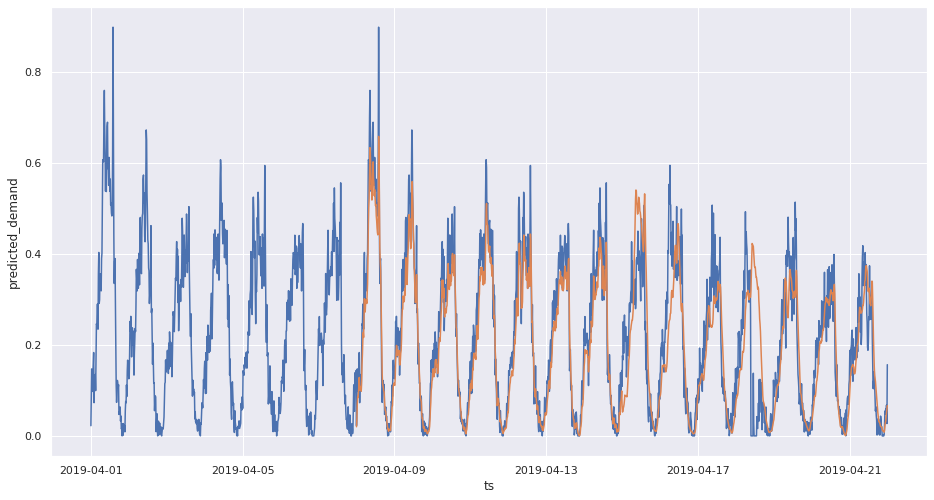

In [46]:
fig, ax = plt.subplots()
sns.set(style="darkgrid")
sns.set(rc={'figure.figsize':(15.7,8.27)})
ax = sns.lineplot(x="ts", y="actual_demand", data=result_df, ax=ax)
ax = sns.lineplot(x="ts", y="predicted_demand", data=result_df, ci="sd", err_style="band", ax=ax)
#ax = sns.lineplot(x="ts", y="predicted_50_quant", data=result_df, ci=50, ax=ax, legend="full")
#ax = sns.lineplot(x="ts", y="predicted_90_quant", data=result_df, ci=90, ax=ax, legend="full")
#sns.tsplot([result_df.actual_demand, result_df.predicted_demand])